In [1]:
import numpy as np
import pickle as pkl
import matplotlib.pyplot as plt
import networkx as nx
import torch
import os
import dgl
from sklearn.preprocessing import OneHotEncoder

Using backend: pytorch


In [2]:
path = "/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/novelgridworlds_nonov_1_easy/"
files = list(filter(lambda x: ".bin" in x,os.listdir(path)))

states = []
for name in files:
    f = open(os.path.join(path,name),'rb')
    a = pkl.load(f)
    states.extend(a)
    f.close()

In [3]:
print(len(states))

20482


In [4]:
max_graph = 200
max_items = 50

# Order of standard nodes
agent, {actions}, {items}, {positions}

In [5]:
standard_node_ids = {"agent":0}
action_ids = {key:val for val,key in states[0]["action_str"].items()}
standard_node_ids.update(action_ids)
standard_node_ids.update(states[0]["items_id"])
item_ids = states[0]["items_id"]
item_ids.update({"agent":0})
ids_item = {val:key for key,val in item_ids.items()}
mp = states[0]["map"]

n_nodes = len(standard_node_ids)
standard_node_ids = {key:val for key,val in zip(standard_node_ids.keys(),range(n_nodes))}

In [6]:
g = nx.Graph(np.zeros((n_nodes,n_nodes)))

In [7]:
ids_items = {val:key for key,val in item_ids.items()}
ids_items

{1: 'crafting_table',
 2: 'plank',
 3: 'pogo_stick',
 4: 'rubber',
 5: 'stick',
 6: 'tree_log',
 7: 'tree_tap',
 8: 'wall',
 0: 'agent'}

In [8]:
standard_node_ids

{'agent': 0,
 'Forward': 1,
 'Left': 2,
 'Right': 3,
 'Break': 4,
 'Place_tree_tap': 5,
 'Extract_rubber': 6,
 'Craft_plank': 7,
 'Craft_pogo_stick': 8,
 'Craft_stick': 9,
 'Craft_tree_tap': 10,
 'Select_crafting_table': 11,
 'Select_plank': 12,
 'Select_pogo_stick': 13,
 'Select_rubber': 14,
 'Select_stick': 15,
 'Select_tree_log': 16,
 'Select_tree_tap': 17,
 'crafting_table': 18,
 'plank': 19,
 'pogo_stick': 20,
 'rubber': 21,
 'stick': 22,
 'tree_log': 23,
 'tree_tap': 24,
 'wall': 25}

In [9]:
def int_to_onehot(n,mx):
    
    a = np.zeros((mx,))
    a[n]=1
    return a

def make_map(standard_node_ids, ids_items, mp):
    onehot_map = np.zeros((*mp.shape,max_items))
    for i in range(len(mp)):
        for j in range(len(mp[i])):
           onehot_map[i,j] = int_to_onehot(mp[i,j],max_items)

    return onehot_map

#onehot_map = make_map(standard_node_ids,ids_items,mp)
            


In [33]:

def draw_positions(node_ids):
    id2pos = {val:key for key,val in node_ids.items()}
    id2label = {val:key for key,val in node_ids.items()}
    id2color = {{val:key for key,val in node_ids.items()}}
    
    #id2pos
    count =0
    alt = [-3,0,3]
    
    for key,val in node_ids.items():
        count+=1
        id2pos[val] = [count,10+alt[count%3]]
        id2color[val] = "green"
        
        
    id2pos[node_ids["agent"]] = [14,6]
    id2color[node_ids["agent"]] = "blue"
    count = 0
    for act in states[0]["action_str"].values():
        id2pos[node_ids[act]] = [10,4+count]
        count+=1
        id2label[node_ids[act]] = count
        
    print(id2pos)
    return id2pos, id2label

In [34]:
#id2label = {val:key for key,val in standard_node_ids.items()}

def make_map_shallow(node_ids,ids_item,mp):
    new_mp = mp.copy()
    for i in range(mp.shape[0]):
        for j in range(mp.shape[1]):
            if mp[i,j]!=-1 and mp[i,j]!=0:
                new_mp[i,j] = node_ids[ids_item[mp[i,j]]]
    return new_mp

In [35]:
def make_graph(state, standard_node_ids):
    
    action_ids = {key:val for val,key in state["action_str"].items()}
    

    item_ids = state["items_id"]
    ids_item = {val:key for key,val in item_ids.items()}
    mp = state["map"]
    mp[mp==0]=-1
    mp[state["agent_location"]] = 0
    recipes = state["recipes"]
    
    new_nodes = {}
    node_ids = {"agent":0}
    node_types = {0:0}
    max_id = max(standard_node_ids.values())
    
    ####################################################
    #
    # Node Ids
    #
    # Node types:
    #   0:agent
    #   1:actions
    #   2:items
    #   3:positions
    for key,val in action_ids.items():
        if key in standard_node_ids:
            node_ids[key] = standard_node_ids[key]
            node_types[node_ids[key]] = 1
        else:
            max_id+=1
            new_nodes[key]=max_id
            node_types[max_id] = 1
    
    
    for key,val in item_ids.items():
        if key in standard_node_ids:
            node_ids[key] = standard_node_ids[key]
            node_types[node_ids[key]] =2
        else:
            max_id+=1
            new_nodes[key]=max_id
            node_types[max_id] = 2

    node_ids.update(new_nodes)
    inventory_g = nx.Graph(np.zeros((len(node_ids),len(node_ids))))
    recipe_g = nx.Graph(np.zeros((len(node_ids),len(node_ids)))) 
    action_g = nx.Graph(np.zeros((len(node_ids),len(node_ids))))       
    u = []
    v = []
    edge_type = []
    edge_norm = []
    #
    #
    #
    ###################################################
    #
    # Edges
    #
    # Edge labels:
    #      0: entity location
    #      1: inventory
    #      2: location_edges
    #      3: action
    #      4: recipe
    #
    
    


    inventory = state["inventory_items_quantity"]
    for key,val in inventory.items():
        if val>0:
            e = (node_ids["agent"],node_ids[key])
            inventory_g.add_edge(*e, attr = {"weight":val})
            u.append(e[0])
            v.append(e[1])
            edge_norm.append(val)
            edge_type.append(1)

    def get_adjacent_pos(pos):
        x,y = pos
        return [(x-1,y),(x+1,y),(x,y-1),(x,y+1)]

    
    e = (node_ids["agent"],node_ids[state["action_str"][state["last_action"]]])
    action_g.add_edge(*e)  
    u.append(e[0])
    v.append(e[1])
    for key,val in node_ids.items():
        u.append(val)
        v.append(val)
        edge_norm.append(1)
        edge_type.append(0)

    edge_norm.append(1)
    edge_type.append(3)


    for target,val in recipes.items():
        target_id = node_ids[target]
        for ing in val["input"]:
            ing_id = node_ids[ing]
            u.append(target_id)
            v.append(ing_id)
            edge_norm.append(1)
            edge_type.append(4)

    tmp = [i for i in u]
    
    u.extend(v)
    v.extend(tmp)


    edge_norm.extend(edge_norm)
    edge_type.extend(edge_type)
    u = torch.IntTensor(u)
    v = torch.IntTensor(v)
    
    edge_norm = torch.Tensor(edge_norm)
    edge_type = torch.IntTensor(edge_type)


    



    g = dgl.DGLGraph((u,v))
    
    g.edata.update({'rel_type': edge_type, 'norm': edge_norm})
    tmp = torch.IntTensor(list(node_ids.values()))
    
    node_onehot_encoding = torch.nn.functional.one_hot(tmp.to(torch.int64), max_items)
    #features = np.zeros((tmp.shape[0],4))
    #directions
    #features[node_ids["agent"]] = int_to_onehot()

    g.ndata["h"]=node_onehot_encoding
    g = dgl.add_self_loop(g)
    is_last = state["last_done"]
    
    onehot_map = make_map_shallow(node_ids,ids_item,mp)
    


    #print(torch.max(tmp))
    #
    #
    #
    ###################################################
    return g,onehot_map, node_ids, is_last#position_g, inventory_g, recipe_g, node_ids

{0: [14, 6], 1: [10, 4], 2: [10, 5], 3: [10, 6], 4: [10, 7], 5: [10, 8], 6: [10, 9], 7: [10, 10], 8: [10, 11], 9: [10, 12], 10: [10, 13], 11: [10, 14], 12: [10, 15], 13: [10, 16], 14: [10, 17], 15: [10, 18], 16: [10, 19], 17: [10, 20], 18: [19, 10], 19: [20, 13], 20: [21, 7], 21: [22, 10], 22: [23, 13], 23: [24, 7], 24: [25, 10], 25: [26, 13]}


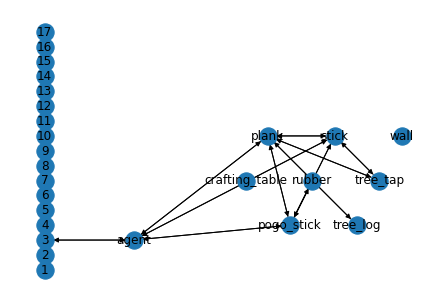

In [36]:
#position_g, inventory_g, recipe_g, node_ids = make_graph(states[2],standard_node_ids)
g, onehot_map,node_ids, is_last = make_graph(states[0],standard_node_ids)
id2pos,id2label = draw_positions(node_ids)
nx.draw(g.to_networkx(),pos = id2pos,labels = id2label)

In [24]:
nov_path = "/media/panagiotis/TOSHIBA EXT1/Research/Novelty_detection/datasets/gridworlds_data/test"
files = list(filter(lambda x: ".bin" in x,os.listdir(nov_path)))

new_states = []
for name in files:
    f = open(os.path.join(nov_path,name),'rb')
    a = pkl.load(f)
    new_states.extend(a)
    f.close()

{0: [14, 6], 1: [8, 4], 2: [8, 5], 3: [8, 6], 4: [8, 7], 5: [8, 8], 6: [8, 9], 7: [8, 10], 8: [8, 11], 9: [8, 12], 10: [8, 13], 11: [8, 14], 12: [8, 15], 13: [8, 16], 14: [8, 17], 15: [8, 18], 16: [8, 19], 17: [8, 20], 18: [19, 10], 19: [20, 11], 20: [21, 9], 21: [22, 10], 22: [23, 11], 23: [24, 9], 24: [25, 10], 25: [26, 11], 26: [27, 9], 27: [28, 10]}


False

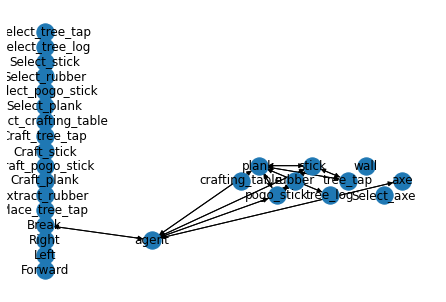

In [16]:
g, onehot_map, node_ids, is_last = make_graph(new_states[1],standard_node_ids)
id2pos,id2label = draw_positions(node_ids)
nx.draw(g.to_networkx(),pos = id2pos,labels = id2label)
is_last

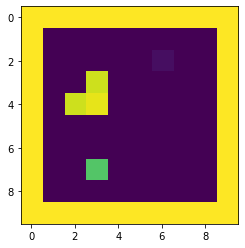

In [17]:
plt.imshow(onehot_map)

In [18]:
import pickle
import tqdm
normal_graphs = [[]]
normal_maps = [[]]
normal_node_ids = [[]]
for s in tqdm.tqdm(states):
    g, onehot_map, node_ids,is_last = make_graph(s,standard_node_ids)
    if is_last:
        normal_graphs[-1].append(g)
        normal_maps[-1].append(onehot_map)
        normal_node_ids[-1].append(node_ids)
        normal_graphs.append([])
        normal_maps.append([])
        normal_node_ids.append([])
    else:
        normal_graphs[-1].append(g)
        normal_maps[-1].append(onehot_map)
        normal_node_ids[-1].append(node_ids)

f = open(os.path.join(path,"normal_graphs_maps.pkl"),'wb')
pickle.dump([normal_graphs,normal_maps],f)
f.close()


f = open(os.path.join(path,"normal_nodeids.pkl"),'wb')
pickle.dump(normal_node_ids,f)
f.close()

100%|██████████| 20482/20482 [00:18<00:00, 1124.93it/s]


In [19]:
import pickle
import tqdm
novel_graphs = [[]]
novel_maps = [[]]
novel_node_ids = [[]]
for s in tqdm.tqdm(new_states):
    g, onehot_map, node_ids,is_last = make_graph(s,standard_node_ids)
    if is_last:
        novel_graphs[-1].append(g)
        novel_maps[-1].append(onehot_map)
        novel_node_ids[-1].append(node_ids)
        novel_graphs.append([])
        novel_maps.append([])
        novel_node_ids.append([])
    else:
        novel_graphs[-1].append(g)
        novel_maps[-1].append(onehot_map)
        novel_node_ids[-1].append(node_ids)

f = open(os.path.join(nov_path,"valid_graphs_maps.pkl"),'wb')
pickle.dump([novel_graphs,novel_maps],f)
f.close()


f = open(os.path.join(nov_path,"valid_nodeids.pkl"),'wb')
pickle.dump(novel_node_ids,f)
f.close()

100%|██████████| 273/273 [00:00<00:00, 1153.92it/s]
